<a href="https://colab.research.google.com/github/lauragabrysiak/mitx_applied_data_science/blob/main/CAPSTONE_music_recsys_gabrysiak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Music Recommendation System**

## **Problem Definition**

### **The Context:**

With the advent of technology, societies have become more efficient with their lives. At the same time, however, individual human lives have also become more fast-paced and distracted, leaving little time to explore artistic pursuits. Also, technology has made significant advancements in the ability to coexist with art and general entertainment. It has in fact made it easier for humans with a shortage of time to find and consume good content.

Almost every internet-based company's revenue relies on the time consumers spend on its platform. These companies need to be able to figure out what kind of content is needed in order to increase customer time spent and make their experience better. Therefore, one of the key challenges for these companies is figuring out what kind of content their customers are most likely to consume.
Spotify is one such audio content provider with a huge market base across the world. With the ever-increasing volume of songs becoming available on the Internet, searching for songs of interest has become a tedious task in itself.

However, Spotify has grown significantly in the market because of its ability to recommend the 'best' next song to each and every customer based on a huge
preference database gathered over time - millions of customers and billions of songs. This is done by using smart recommendation systems that can recommend songs based on users' likes/dislikes.

Source: https://olympus.mygreatlearning.com/courses/87799/files/7049375?module_item_id=3469914

#### **Why is this problem important to solve?**

Competitive advange by user experience and insights + data as a product.

### **The objective:**

#### **What is the intended goal?**
 Build a recommendation system to propose the top 10 songs for a user based on the likelihood of listening to those songs.

####**The key questions:**

What are the key questions that need to be answered?

*   What is the goal of the recommendation system?
*   Who are the users?
*   What data is available?
*   How will the system handle new users and items?
*   What algorithms and models will be used?
*   How will the system handle diversity and serendipity?
*   What is the system's scalability and performance?
*   Are there any technical or data limitations

### **The problem formulation**:

**What is it that we are trying to solve using data science?**

Recommendation systems in data science help solve challenges related to information overload, user engagement, personalization, and more. These systems filter and prioritize items based on user preferences and tailor suggestions based on individual behavior, providing a personalized experience that encourages exploration and enhances user engagement. They also increase sales and revenue by analyzing user behavior and preferences to suggest products more likely to result in purchases. Additionally, they optimize content delivery and maximize click-through rates by suggesting items that align with user interests and preferences. Overall, recommendation systems use data science techniques to enhance user experiences and drive business outcomes.

## **Data Dictionary**

The core data is the Taste Profile Subset released by the Echo Nest as part of the Million Song Dataset. There are two files in this dataset. The first file contains the details about the song id, titles, release, artist name, and the year of release. The second file contains the user id, song id, and the play count of users.

## S1: song_data
*   song_id - A unique id given to every song
*   title - Title of the song
*   Release - Name of the released album
*   Artist_name - Name of the artist
*   year - Year of release

## S2: count_data
*   user _id - A unique id given to the user
*   song_id - A unique id given to the song
*   play_count - Number of times the song was played

## **Data Source**
http://millionsongdataset.com/

## Data Understanding


### **Importing Libraries and the Dataset**

#### Mount Drive

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#### Install Libraries

In [3]:
# Installing surprise library
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163478 sha256=88d70a9af699d667acb55971a9bef6d081c02306ce285c4c784652bd60dc8229
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [4]:
# Installing Pandas Profile
!pip install -U ydata-profiling[notebook]==4.0.0 matplotlib==3.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.7 MB/s 

In [5]:
# Installing Pandas Profile
!pip install spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 6.0 MB/s eta 0:00:00


#### Import Libraries

In [1]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')
from collections import defaultdict             # A dictionary output that does not raise a key error

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # data visualization
import seaborn as sns                           # data visualization advanced

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

from ydata_profiling import ProfileReport       # Adding pandas report
from scipy.stats import pearsonr                # pearson correlation

In [7]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import SpotifyException

### **Datasets**

#### Import datasets

In [3]:
# Importing the datasets
song_df = pd.read_csv('/content/sample_data/song_data.csv'
                  , on_bad_lines='skip')
count_df = pd.read_csv('/content/sample_data/count_data.csv'
                  , on_bad_lines='skip')

In [4]:
print("song ds", song_df.shape)
print("count ds", count_df.shape)

song ds (1000000, 5)
count ds (1288090, 4)


In [5]:
print(song_df.info())   # there is some missing information (title (-15) /release (-5) )
print("\n")
print(count_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999985 non-null   object
 2   release      999995 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288090 entries, 0 to 1288089
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1288090 non-null  int64  
 1   user_id     1288090 non-null  object 
 2   song_id     1288089 non-null  object 
 3   play_count  1288089 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 39.3+ MB
None


#### Data Preparation

#### S1) **Count dataset**

Dataset of 2000000 x 3 variables. Includes the number of times that songs were played and by who (user). Includes the song_id as primary key for reference

In [6]:
count_df.columns = ['index','user_id', 'song_id', 'play_count'] # Adding column names
count_df_copy = count_df .copy(deep = True) # backup copy
count_df = count_df.drop('index', axis = 1) # Dropping index # Drop the column 'Unnamed: 0' // already done

In [7]:
# See top 10 records of count_df data
count_df.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1.0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2.0
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1.0
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1.0
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1.0


In [8]:
# See the info of the count_df data
count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288090 entries, 0 to 1288089
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     1288090 non-null  object 
 1   song_id     1288089 non-null  object 
 2   play_count  1288089 non-null  float64
dtypes: float64(1), object(2)
memory usage: 29.5+ MB


In [9]:
#### Pandas Report original dataset
# Use df_copy
count_profile = ProfileReport(count_df
                        , title="Count Info Report"
                        #, subtitle="Original Dataset"
                        )

In [ ]:
count_profile.to_notebook_iframe()

#### S2) **Song dataset**
Dataset defined by 1000000 x 5 variables. Includes the song information (song_title, song_release, song_artist, song_year) along with song_id which can be used for merging as as a reference

In [ ]:
print(song_df.shape, "\n", song_df.head(3))

In [11]:
temp = song_df

temp = temp.dropna(axis=0)                          # drop na's
#temp = temp.drop_duplicates()                        # drop duplicate rows  | To do after merge
#temp = temp[temp['year'] != 0]                 # dropping all year info  == 0 | To do after merge

print(temp.shape, "\n", temp.head(3))
#song_df = temp

(999980, 5) 
               song_id              title                release  \
0  SOQMMHC12AB0180CB8       Silent Night  Monster Ballads X-Mas   
1  SOVFVAK12A8C1350D9        Tanssi vaan            Karkuteillä   
2  SOGTUKN12AB017F4F1  No One Could Ever                 Butter   

        artist_name  year  
0  Faster Pussy cat  2003  
1  Karkkiautomaatti  1995  
2    Hudson Mohawke  2006  


In [12]:
# See top 10 records of song_df data
temp.columns = ['song_id','song_title', 'song_release', 'song_artist', 'song_year'] # Adding column names
temp.sample(5)

,song_id,song_title,song_release,song_artist,song_year
293882,SOBYIQF12AB0188F85,Sneaky Flutes 2,Sneaky Flutes,Swirlies,1995
82003,SOMKVDK12A67AE227F,Runaway (Album Version),Hybrid Theory,Linkin Park,2000
803588,SOAUOWH12AB0185E57,Novembertraum,Novembertraum,Joachim Spieth,0
478500,SOSWRWA12A8C13BE8C,Capoicity,Internationalist,Powderfinger,1998
532496,SOAQSYZ12A8C136B4F,Long Distance Call,Blue Notes,Paul Burch & The WPA Ballclub,0


In [13]:
# See the info of the song_df data
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999980 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   song_id       999980 non-null  object
 1   song_title    999980 non-null  object
 2   song_release  999980 non-null  object
 3   song_artist   999980 non-null  object
 4   song_year     999980 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 45.8+ MB


##### Using the Spotify Web API for data augmentation

In [ ]:
song_df['song_id'][1]

[Spotify Web Developer instructions](https://developer.spotify.com/documentation/web-api/concepts/spotify-uris-ids)

[Spotify Web API instructions](https://developer.spotify.com/documentation/web-api/reference/get-an-artist)

[Using Spotify Web App](https://garrecht-metzger.medium.com/getting-started-with-the-spotify-api-using-spotipy-bfb2340293c9)




In [ ]:
# Replace 'YOUR_CLIENT_ID', 'YOUR_CLIENT_SECRET', and 'YOUR_REDIRECT_URI' with your actual credentials
client_id = '930c85172af549c7bed7661f025edf11'
client_secret = 'b33c88126c014981b3fc1d7c426d3a1c'
redirect_uri = 'http://localhost:8888/callback'

# Set up Spotify API credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

# Example: Augmenting a dataset using song IDs
song_ids = temp['song_id']                   #--> Spotify IDs seem not to be valid

# Initialize a list to store augmented data
augmented_data = []

# Retrieve information for each song ID
for song_id in song_ids:
    try:
        track_info = sp.track(song_id)
        artist_info = sp.artist(track_info['artists'][0]['id'])

        # Extract relevant information
        track_name = track_info['name']
        artist_name = artist_info['name']
        release_date = track_info['album']['release_date']
        popularity = track_info['popularity']
        artist_genres = artist_info['genres']

        # Add the augmented data to the list
        augmented_data.append({
            'song_id': song_id,
            'track_name': track_name,
            'artist_name': artist_name,
            'release_date': release_date,
            'popularity': popularity,
            'genres': artist_genres
        })
    #except SpotifyException as e:
        #print(f"Error for song ID {song_id}: {e}")

# Convert the augmented data to a DataFrame
augmented_df = pd.DataFrame(augmented_data)

# Display the augmented DataFrame
print("Augmented DataFrame:")
print(augmented_df)

Spotify IDs seem not to be valid

##### Text normalization

In [14]:
## Normalize Text variables

import re
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer

# Function to perform text normalization
def normalize_text(text):

    text = text.lower()                                                           # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)                                           # Remove punctuation
    # stop_words = set(stopwords.words('english'))                                # Remove stop words (using NLTK library)
    # text = ' '.join([word for word in text.split() if word not in stop_words])
    # stemmer = PorterStemmer()                                                   # Stemming (using Porter Stemmer from NLTK)
    # text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [15]:
# Apply the normalization function to the 'TextColumn'
temp['song_title'] = temp['song_title'].apply(normalize_text)
temp['song_release'] = temp['song_release'].apply(normalize_text)
temp['song_artist'] = temp['song_artist'].apply(normalize_text)

In [16]:
song_df = temp
#temp = []

##### Pandas Report Songs Dataset

In [17]:
#### Pandas Report original dataset
# Use df_copy
profile_song = ProfileReport(song_df
                        , title="Song Info Report"
                        #, subtitle="Original Dataset"
                        )

In [ ]:
profile_song.to_notebook_iframe()

#### **Observations and Insights:**

*   Song data:
    *  data structure: Prunned data frame has 5 variables (4 cat and 1 num) x 999980 observations. All other observations (20) were dropped as they had na's.
    *  There are 505 rows (0.1%)  that are duplicated that will  be dropped
    *  48.4% of year var has values = 0 values. The ranges of year goes from 1922 - 2011 --> FIXED


*   Count data:
    *  Dataset has no missing data or dupliate rows
    *  Mean value of song_count is 3.0454845 whit t=values ranging from 1 - 2000
    *  56.9% of songs are played 1 x. Clear presence of outliers


#### Create subset for rapid testing (0.1%)

In [ ]:
# Create sample subsets to go through project quickly

count_df = count_df .sample(frac=0.01, random_state=42)
song_df = song_df.sample(frac=0.01, random_state=42)

### **Final Dataset**

In [18]:
# Left merge the count_df and song_df data on "song_id". Drop duplicates from song_df data simultaneously
## Name the obtained dataframe as "df"

temp = pd.merge( count_df # 2000000
                , song_df # 515132 (after cleaning)
                , on='song_id'
                , how='inner'       # when performing a left join NA"s are created
                )

# df= temp.drop_duplicates(subset='song_id')

In [19]:
temp.shape

(1343930, 7)

In [20]:
temp.head(10)

,user_id,song_id,play_count,song_title,song_release,song_artist,song_year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1.0,the cove,thicker than water,jack johnson,0
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1.0,the cove,thicker than water,jack johnson,0
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3.0,the cove,thicker than water,jack johnson,0
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1.0,the cove,thicker than water,jack johnson,0
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6.0,the cove,thicker than water,jack johnson,0
5,7a4b8e7d2905d13422418b4f48cc85100892e013,SOAKIMP12A8C130995,6.0,the cove,thicker than water,jack johnson,0
6,b4a678fb729bfca6031a96948996ea909ca06fe5,SOAKIMP12A8C130995,2.0,the cove,thicker than water,jack johnson,0
7,33280fc74b168e2667a2da5c6ab4df4cc6edfb23,SOAKIMP12A8C130995,1.0,the cove,thicker than water,jack johnson,0
8,be21ec120193effd2a5e545c4bafa2e1f92e9816,SOAKIMP12A8C130995,1.0,the cove,thicker than water,jack johnson,0
9,6fbb9ff93663f3c3ad206a9325d90b19278618b4,SOAKIMP12A8C130995,2.0,the cove,thicker than water,jack johnson,0


In [26]:
temp = temp.drop_duplicates()                        # drop duplicate rows  | To do after merge
temp = temp[temp['song_year'] != 0]                 # dropping all year info  == 0 | To do after merge

In [22]:
df_final = temp

In [23]:
df_final.shape

(1080326, 7)

**Think About It:** As the user_id and song_id are encrypted. Can they be encoded to numeric features?

## Dataset prunning

In [ ]:
# Apply label encoding for "user_id" and "song_id"


**Think About It:** As the data also contains users who have listened to very few songs and vice versa, is it required to filter the data so that it contains users who have listened to a good count of songs and vice versa?

A dataset of size 2000000 rows x 7 columns can be quite large and may require a lot of computing resources to process. This can lead to long processing times and can make it difficult to train and evaluate your model efficiently.
In order to address this issue, it may be necessary to trim down your dataset to a more manageable size.

In [27]:
print(df_final.info())
print("\n")
# check play_count
print(df_final.describe(exclude='object').transpose())
# deal with year = 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1080326 entries, 118 to 1343929
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   user_id       1080326 non-null  object 
 1   song_id       1080326 non-null  object 
 2   play_count    1080326 non-null  float64
 3   song_title    1080326 non-null  object 
 4   song_release  1080326 non-null  object 
 5   song_artist   1080326 non-null  object 
 6   song_year     1080326 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 65.9+ MB
None


                count         mean       std     min     25%     50%     75%  \
play_count  1080326.0     2.978029  6.508300     1.0     1.0     1.0     3.0   
song_year   1080326.0  2000.997132  9.716876  1954.0  1999.0  2005.0  2008.0   

               max  
play_count  2213.0  
song_year   2010.0  


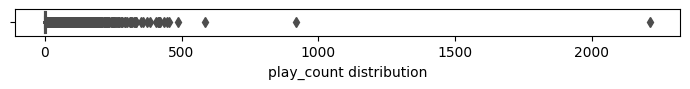

In [28]:
fig = plt.figure(figsize= (7,1))
sns.boxplot(x = df_final["play_count"]
            , color = 'grey').set_xlabel("play_count distribution")
fig.tight_layout()

In [29]:
# Prunning outliers by Calculating the IQR (Interquartile Range)
temp = df_final
f1p = temp['play_count'].quantile(0.01)
l1p = temp['play_count'].quantile(0.99)
IQR = l1p - f1p

# Define a threshold for identifying outliers
outlier_threshold = 1.5

# Remove outliers
df_no_outliers = temp[(temp['play_count'] >= f1p - outlier_threshold * IQR) & (temp['play_count'] <= l1p + outlier_threshold * IQR)]

In [30]:
print(df_no_outliers.describe(exclude='object').transpose())   # any songs with more than 63% plays should be dropped

                count         mean       std     min     25%     50%     75%  \
play_count  1078816.0     2.840282  4.477703     1.0     1.0     1.0     3.0   
song_year   1078816.0  2000.999237  9.716400  1954.0  1999.0  2005.0  2008.0   

               max  
play_count    61.0  
song_year   2010.0  


Todo: Should Outliers be also taken into consideration for selection criteria

##### Dataset Pruning by Selection Criteria: Ratings CUTOFF

In [31]:
# Get the column containing the users
users = df_final.user_id
# Create a dictionary from users to their number of songs
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [32]:
# We want our users to have listened at least 90 songs
RATINGS_CUTOFF = 90
remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df = df_final.loc[~df_final.user_id.isin(remove_users)]

In [33]:
df.shape

(191828, 7)

##### Dataset Pruning by Selection Criteria: User CUTOFF

In [34]:
# Get the column containing the songs
songs = df.song_id
# Create a dictionary from songs to their number of users
ratings_count = dict()
for song in songs:
    # If we already have the song, just add 1 to their rating count
    if song in ratings_count:
        ratings_count[song] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[song] = 1

In [35]:
# We want our song to be listened by at least 120 users to be considered (why?)
RATINGS_CUTOFF = 120
remove_songs = []
for song, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_songs.append(song)
df_final= df.loc[~df.song_id.isin(remove_songs)]

In [36]:
df_final.shape

(31959, 7)

##### Dataset Pruning by Selection Criteria: Play_Count CUTOFF

In [37]:
# Drop records with play_count more than(>) 5
df_final=df_final[df_final.play_count<=5]

In [38]:
# Check the shape of the data
df_final.shape

(29177, 7)

A total of 138285 x 7 remains after applying pruning selection criteria.

In [ ]:
#### Pandas Report original dataset
# Use df_copy
profile_final = ProfileReport(df_final
                        , title="Final dataset Report"
                        #, subtitle="Original Dataset"
                        )

In [ ]:
profile_final.to_notebook_iframe()

Final Dataset (df_final)

| Dataset statistics            |         |
| ----------------------------- | ------- |
| Number of variables           | 7       |
| Number of observations        | 70379   |
| Missing cells                 | 0       |
| Missing cells (%)             | 0.00%   |
| Duplicate rows                | 0       |
| Duplicate rows (%)            | 0.00%   |
| Total size in memory          | 4.3 MiB |
| Average record size in memory | 64.0 B  |

Alerts:

      *  song_year has 23399 (16.9%) zeros ---> FIXED


## **Exploratory Data Analysis**

### **Numerical Variables EDA**

In [39]:
# numerical variables
print(df_final.describe(exclude='object').transpose())

              count         mean       std     min     25%     50%     75%  \
play_count  29177.0     1.759057  1.093425     1.0     1.0     1.0     2.0   
song_year   29177.0  2004.265380  6.664890  1973.0  2002.0  2007.0  2009.0   

               max  
play_count     5.0  
song_year   2010.0  


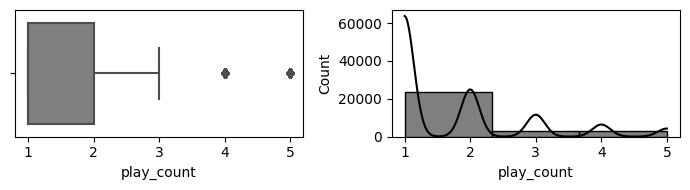

In [40]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 2))
# p1: top users by ratings
#sns.barplot(x='song_id', y='play_count', data=df_final, color='black', ax=axes[0])
sns.boxplot(x = df_final["play_count"], color = 'grey', ax=axes[0])
# p2: ratings distribution (min = 5 given selection criteria)
sns.histplot(df_final['play_count'], bins=3, kde=True, color='black', ax=axes[1])
fig.tight_layout()

### **Categorical Variables EDA**

In [41]:
# categorical variables
print(df_final.describe(include='object').transpose())

              count unique                                       top  freq
user_id       29177   1409  7c80116b2a5c6602ca60fc40ef932e12fd304a69   133
song_id       29177    156                        SOWCKVR12A8C142411   748
song_title    29177    160                              use somebody   748
song_release  29177    153                                 my worlds   617
song_artist   29177     98                                  coldplay  2239


In [43]:
# Multivariate categorical analysis
df_final.groupby(['song_id','song_title','song_year'])['play_count'].agg(['mean', 'count']).sort_values(by='count', ascending=False).reset_index().head()

,song_id,song_title,song_year,mean,count
0,SOWCKVR12A8C142411,use somebody,2008,1.954545,748
1,SOPXKYD12A6D4FA876,yellow,2000,1.757576,594
2,SOKUAGP12A8C133B94,dont stop the music,2007,1.632530,498
3,SODGVGW12AC9075A8D,somebody to love,2010,2.067961,412
4,SOTWSXL12A8C143349,love story,2008,1.886139,404


Songs played in a year

In [45]:
# Find out the number of songs played in a year
  # Hint: Use groupby function on the 'year' column
top_songs_year = df_final.groupby(['song_year'])['play_count'].agg(['mean', 'count']).sort_values(['song_year'],ascending=False).reset_index()
round(top_songs_year).head()

,song_year,mean,count
0,2010,2.0,1999
1,2009,2.0,6345
2,2008,2.0,4228
3,2007,2.0,2685
4,2006,2.0,1990


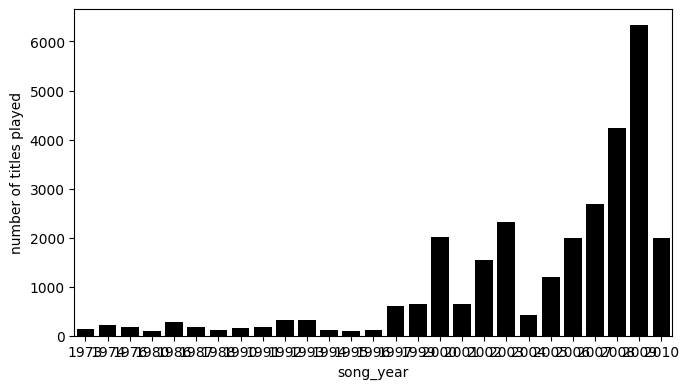

In [46]:
# Create a barplot plot with y label as "number of titles played" and x -axis year

# Set the figure size
fig = plt.figure(figsize= (7,4))
sns.barplot(x='song_year', y='count', data=top_songs_year, color='black')
# Set the x label of the plot
plt.xlabel("song_year")
# Set the y label of the plot
plt.ylabel('number of titles played')
# Show the plot
fig.tight_layout()

#### **Observations and Insights:**

Unique ocurrences:

                  *   There are 2187 unique users
                  *   There are 343 unique songs_ids
                  *   There are 346 unique song_titles
                  *   There are 275 unique song_releases
                  *   There are 152 unique song_artists

Top ocurrences:

*    Top songs

          *   Top songs_id is SOWCKVR12A8C142411 with 1538 freq
          *   Top song_title is use somebody with 1538 - most probably with SOWCKVR12A8C142411 song_id

| rank | song_title          | freq | freq_% |
| ---- | ------------------- | ---- | ------ |
| 1    | use somebody        | 1602 | 1.20%  |
| 2    | yellow              | 1264 | 0.90%  |
| 3    | dont stop the music | 960  | 0.70%  |
| 4    | somebody to love    | 920  | 0.70%  |
| 5    | love story          | 910  | 0.70%  |

*    Top releases

          *   Top song_release is my worlds with 1913 freq

| rank | song_release                     | freq | freq_% |
| ---- | -------------------------------- | ---- | ------ |
| 1    | my worlds                        | 1967 | 1.40%  |
| 2    | ray guns are not just the future | 1855 | 1.30%  |
| 3    | vampire weekend                  | 1754 | 1.30%  |
| 4    | hell train                       | 1708 | 1.20%  |
| 5    | give up                          | 1632 | 1.20%  |

*    Top song_artists
          *   Top song_artists is coldplay with 6313 freq

| rank | song_artist          | freq | freq_% |
| ---- | -------------------- | ---- | ------ |
| 1    | coldplay             | 6527 | 4.70%  |
| 2    | kings of leon        | 4441 | 3.20%  |
| 3    | the killers          | 4254 | 3.10%  |
| 4    | florence the machine | 3046 | 2.20%  |
| 5    | justin bieber        | 2858 | 2.10%  |

*   Top users

        *   Top user is ce5c912bb8044f23fc0fc31bd986b8d0a7303db5 with 278 freq




Now that we have explored the data, let's apply different algorithms to build recommendation systems.

**Note:** Use the shorter version of the data, i.e., the data after the cutoffs as used in Milestone 1.

## Building various models

### **Popularity-Based Recommendation Systems**

Let's take the count and sum of play counts of the songs and build the popularity recommendation systems based on the sum of play counts.

In [47]:
# Calculating average play_count
       # Hint: Use groupby function on the song_id column

avg_counts= df_final.groupby('song_id')['play_count'].mean().reset_index()

# Calculating the frequency a song is played
      # Hint: Use groupby function on the song_id column
count_counts = df_final.groupby('song_id')['play_count'].count().reset_index()

In [48]:
# Making a dataframe with the average_count and play_freq
avg_play_counts = df_final.groupby(['song_id','song_title'])['play_count'].agg(['mean', 'count']).sort_values(by='count', ascending=False).reset_index()

# Let us see the first five records of the final_play dataset
avg_play_counts.head()

,song_id,song_title,mean,count
0,SOWCKVR12A8C142411,use somebody,1.954545,748
1,SOPXKYD12A6D4FA876,yellow,1.757576,594
2,SOKUAGP12A8C133B94,dont stop the music,1.632530,498
3,SODGVGW12AC9075A8D,somebody to love,2.067961,412
4,SOTWSXL12A8C143349,love story,1.886139,404


Now, let's create a function to find the top n songs for a recommendation based on the average play count of song. We can also add a threshold for a minimum number of playcounts for a song to be considered for recommendation.

In [49]:
# Build the function to find top n songs

# p1: avg_play_counts: dataframe to sort
# p2: n: n products
# p3: min_playcounts: def what a min interaction is (min())

def top_n_songs(df, n, min_playcount_def):

    # Finding songs with minimum number of playcounts
    #min_playcount_def = df['count'].min()                                     # def a min playcount
    min_recommendations = df[df['count'] >=  min_playcount_def]      # recommendations that comprise def of min playcounts had to be fixed to be >= as they are min requirements

    # Sorting values with respect to average rating
    sorted_recommendations = min_recommendations.sort_values(['count'], ascending = False)#.reset_index()

    return sorted_recommendations[:n]

In [50]:
# Testing function

result = top_n_songs(avg_play_counts, 3, 5)

test = avg_play_counts[avg_play_counts['count'] >=  5].sort_values(['count'], ascending = False)

print(
      avg_play_counts.head(3)
      , "\n\n"
      , result # getting the index
      , "\n\n"
      , test[:3]
      )

              song_id           song_title      mean  count
0  SOWCKVR12A8C142411         use somebody  1.954545    748
1  SOPXKYD12A6D4FA876               yellow  1.757576    594
2  SOKUAGP12A8C133B94  dont stop the music  1.632530    498 

               song_id           song_title      mean  count
0  SOWCKVR12A8C142411         use somebody  1.954545    748
1  SOPXKYD12A6D4FA876               yellow  1.757576    594
2  SOKUAGP12A8C133B94  dont stop the music  1.632530    498 

               song_id           song_title      mean  count
0  SOWCKVR12A8C142411         use somebody  1.954545    748
1  SOPXKYD12A6D4FA876               yellow  1.757576    594
2  SOKUAGP12A8C133B94  dont stop the music  1.632530    498


In [51]:
# Recommend top 10 songs using the function defined above
top_n_songs(avg_play_counts, 10, 5)

,song_id,song_title,mean,count
0,SOWCKVR12A8C142411,use somebody,1.954545,748
1,SOPXKYD12A6D4FA876,yellow,1.757576,594
2,SOKUAGP12A8C133B94,dont stop the music,1.632530,498
3,SODGVGW12AC9075A8D,somebody to love,2.067961,412
4,SOTWSXL12A8C143349,love story,1.886139,404
5,SOCVTLJ12A6310F0FD,clocks,1.869565,345
6,SOKLRPJ12A8C13C3FE,the scientist,2.005900,339
7,SOPQLBY12A6310E992,creep explicit,1.766154,325
8,SOXVVSM12A8C142224,everlong,1.743750,320
9,SOKOXWU12AF72AD1BC,the real slim shady,1.679487,312


### **User User Similarity-Based Collaborative Filtering**

In this type of recommendation system, we do not need any information about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example playcounts.

To build the user-user-similarity-based and subsequent models we will use the "surprise" library.

In [ ]:
# Install the surprise package using pip. Uncomment and run the below code to do the same

# !pip install surprise
# done

# Import necessary libraries
# To compute the accuracy of models

In order to measure the similarity-based recommendation systems we can use cosine similarity and KNN to find similar users which are the nearest neighbor to the given user (neighboorhoods).

In [52]:
# This class is used to parse a file containing play_counts, data should be in structure - user; item; play_count
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing KFold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

# Class to compute the accuracy of models
from surprise import accuracy


### Some useful functions

Below is the function to calculate precision@k and recall@k, RMSE, and F1_Score@k to evaluate the model performance.

**Think About It:** Which metric should be used for this problem to compare different models?

In [53]:
# The function to calulate the RMSE, precision@k, recall@k, and F_1 score
def precision_recall_at_k(model, k = 30, threshold = 1.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions=model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x : x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)

    # Formula to compute the F-1 score
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))

**Think About It:** In the function precision_recall_at_k above the threshold value used is 1.5. How precision and recall are affected by changing the threshold? What is the intuition behind using the threshold value of 1.5?

In [55]:
# Instantiating Reader scale with expected rating scale
 #use rating scale (0, 5)
reader = Reader(rating_scale = (0, 5)) # min = 0 and max = 5 x played by user

# Loading the dataset
 # Take only "user_id","song_id", and "play_count"
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)      # can be solved with S1 count_df

# Splitting the data into train and test dataset
 # Take test_size = 0.4, random_state = 42
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

In [56]:
# test splitting:
print(reader, "\n\n"
      , data, "\n\n"
      , trainset, "\n\n"
      , testset[:2]
      )




 [('ec200d3fd65aac3f9ba8d5e9d0c7cc8376df4f0c', 'SOOXJDU12A8AE47ECB', 1.0), ('0720ca8f3cc2d0c0c126e784b846785536ddefbc', 'SOCKSGZ12A58A7CA4B', 2.0)]


**Think About It:** How changing the test size would change the results and outputs?

### M1) User - User Similarity

In [57]:
# Build the default user-user-similarity model
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items
 # Use random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options
                         , verbose=False
                         , random_state=1)

# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 30
 # Use sim_user_user model
precision_recall_at_k(sim_user_user)

RMSE: 1.0822
Precision:  0.407
Recall:  0.619
F_1 score:  0.491


**Observations and Insights:**
Baseline model is reasanoble but performance metrics can be improved.

In [85]:
# Predicting play_count for a sample user with a listened song
# Use any user id and song_id
rand_index = np.random.randint(1, len(df_final))

# Predicting rating for a sample user with an interacted product
sim_user_user.predict(df_final['user_id'].iloc[rand_index]
                      , df_final['song_id'].iloc[rand_index]
                     # , r_ui = 5
                      , verbose = True)

user: bd8475385f0aa78830fa6dfce9e7242164b035c8 item: SOTWNDJ12A8C143984 r_ui = None   est = 1.55   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='bd8475385f0aa78830fa6dfce9e7242164b035c8', iid='SOTWNDJ12A8C143984', r_ui=None, est=1.5507813898424894, details={'actual_k': 40, 'was_impossible': False})

In [79]:
# Predicting play_count for a sample user with a song not-listened by the user
 #predict play_count for any sample user

# using a function from the elective project:
def n_users_not_interacted_with(n, data, song_id):
    users_interacted_with_product = set(data[data['song_id'] == song_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [80]:
n_users_not_interacted_with(5, df_final, 'SOMYXWV12A8C14232E')

['ac89005519c8cfac509fabd82fdeb7add90dbc4f',
 'ffdaab327f2fc6b9fa01a4e3e7f41fdd0e468046',
 '0583c12e151732eda5f9396edb59824009a3d6db',
 'ede91b046bb511e8b10cc1201106c3575fb5228c',
 '44234a6f6ae3599350d68067de84cc5810d3ff74']

In [84]:
# Predicting play_count for a sample user with a song not-listened by the user
sim_user_user.predict('ac89005519c8cfac509fabd82fdeb7add90dbc4f'
                      , 'SOMYXWV12A8C14232E'
                      #, r_ui =
                      , verbose = True)

user: ac89005519c8cfac509fabd82fdeb7add90dbc4f item: SOMYXWV12A8C14232E r_ui = None   est = 1.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='ac89005519c8cfac509fabd82fdeb7add90dbc4f', iid='SOMYXWV12A8C14232E', r_ui=None, est=1.873156358071805, details={'actual_k': 40, 'was_impossible': False})

**Observations and Insights:**

Legend:

- uid: This stands for "user id" and represents the unique identifier of the user for whom the prediction was made. In this case, the user ID is '1ee591a388274035a4fd8a4ae40a9589d320bb9d'.

- iid: This stands for "item id" and represents the unique identifier of the item (in this context, a song) for which the prediction was made. In this case, the item ID is 'SODACBL12A8C13C273'.

- r_ui: This represents the "real" or actual rating given by the user for the item. In this case, the actual rating is 5.

- est: This represents the estimated or predicted rating for the user-item pair. In this case, the predicted rating is approximately 1.66.

- details: This is a dictionary containing additional details about the prediction. In this specific case, the details include the number of actual neighbors considered for the prediction (actual_k: 40) and whether the prediction was made without any issues (was_impossible: False).


**Here's a summary of the prediction:**

User '1ee591a388274035a4fd8a4ae40a9589d320bb9d' is predicted to give the song 'SODACBL12A8C13C273' a rating of approximately 1.66. The actual rating given by the user is 5. The prediction is based on collaborative filtering, and 40 nearest neighbors were considered in the process. No issues were encountered during the prediction process (was_impossible: False).

**Hyperparameter Tuning**

Now, let's try to tune the model and see if we can improve the model performance.

In [87]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
        'k':[40],                       # number of neighbors to consider (40 default also equal to the ones in round 1)
        'min_k': [1],                   # minimum number of neighbors to take into account for aggregation
        'sim_options': {
        'name': ['cosine'
                , 'pearson'
                , 'msd']                # similarity metric (cosine or pearson). Consider all options
}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(  KNNBasic
                  , param_grid
                  , measures = ['rmse']
                  , cv = 3
                  , n_jobs = -1)

# Fitting the data
# Use entire data for GridSearch
gs.fit(data)

# Best RMSE score
print(" Best RMSE score", gs.best_score['rmse'], "\n\n")

# Combination of parameters that gave the best RMSE score
print("Combination of parameters for best RMSE score", gs.best_params['rmse'], "\n")

 Best RMSE score 1.011883238430494 


Combination of parameters for best RMSE score {'k': 40, 'min_k': 1, 'sim_options': {'name': 'msd', 'user_based': True}} 



In [ ]:
# Train the best model found in above gridsearch


**Observations and Insights:_________**

In [ ]:
# Predict the play count for a user who has listened to the song. Take user_id 6958, song_id 1671 and r_ui = 2


In [ ]:
# Predict the play count for a song that is not listened to by the user (with user_id 6958)


**Observations and Insights:______________**

**Think About It:** Along with making predictions on listened and unknown songs can we get 5 nearest neighbors (most similar) to a certain song?

In [ ]:
# Use inner id 0


Below we will be implementing a function where the input parameters are:

- data: A **song** dataset
- user_id: A user-id **against which we want the recommendations**
- top_n: The **number of songs we want to recommend**
- algo: The algorithm we want to use **for predicting the play_count**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids


    # Creating an user item interactions matrix


    # Extracting those business ids which the user_id has not visited yet

    # Looping through each of the business ids which user_id has not interacted yet


        # Predicting the ratings for those non visited restaurant ids by this user


        # Appending the predicted ratings

    # Sorting the predicted ratings in descending order


    return # Returing top n highest predicted rating products for this user

In [ ]:
# Make top 5 recommendations for any user_id with a similarity-based recommendation engine


In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_ratings"


**Observations and Insights:______________**

### Correcting the play_counts and Ranking the above songs

In [ ]:
def ranking_songs(recommendations, final_rating):
  # Sort the songs based on play counts

  # Merge with the recommended songs to get predicted play_count

  # Rank the songs based on corrected play_counts

  # Sort the songs based on corrected play_counts

  return

**Think About It:** In the above function to correct the predicted play_count a quantity 1/np.sqrt(n) is subtracted. What is the intuition behind it? Is it also possible to add this quantity instead of subtracting?

In [ ]:
# Applying the ranking_songs function on the final_play data


**Observations and Insights:______________**

### Item Item Similarity-based collaborative filtering recommendation systems

In [ ]:
# Apply the item-item similarity collaborative filtering model with random_state = 1 and evaluate the model performance


**Observations and Insights:______________**

In [ ]:
# Predicting play count for a sample user_id 6958 and song (with song_id 1671) heard by the user


In [ ]:
# Predict the play count for a user that has not listened to the song (with song_id 1671)

**Observations and Insights:______________**

In [ ]:
# Apply grid search for enhancing model performance

# Setting up parameter grid to tune the hyperparameters


# Performing 3-fold cross-validation to tune the hyperparameters

# Fitting the data


# Find the best RMSE score

# Extract the combination of parameters that gave the best RMSE score


**Think About It:** How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html).

In [ ]:
# Apply the best modle found in the grid search


**Observations and Insights:______________**

In [ ]:
# Predict the play_count by a user(user_id 6958) for the song (song_id 1671)


In [ ]:
# Predicting play count for a sample user_id 6958 with song_id 3232 which is not heard by the user


**Observations and Insights:______________**

In [ ]:
# Find five most similar items to the item with inner id 0


In [ ]:
# Making top 5 recommendations for any user_id  with item_item_similarity-based recommendation engine


In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"


In [ ]:
# Applying the ranking_songs function


**Observations and Insights:_________**

### Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

In [ ]:
# Build baseline model using svd


In [ ]:
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui = 2


In [ ]:
# Making a prediction for the user who has not listened to the song (song_id 3232)


#### Improving matrix factorization based recommendation system by tuning its hyperparameters

In [ ]:
# Set the parameter space to tune


# Performe 3-fold grid-search cross-validation


# Fitting data

# Best RMSE score

# Combination of parameters that gave the best RMSE score


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html).

In [ ]:
# Building the optimized SVD model using optimal hyperparameters


**Observations and Insights:_________**

In [ ]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671


In [ ]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating


**Observations and Insights:_________**

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "svd_optimized" algorithm


In [ ]:
# Ranking songs based on above recommendations

**Observations and Insights:_________**

### Cluster Based Recommendation System

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in songs based on how they rate different songs. We cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

In [ ]:
# Make baseline clustering model


In [ ]:
# Making prediction for user_id 6958 and song_id 1671


In [ ]:
# Making prediction for user (userid 6958) for a song(song_id 3232) not heard by the user


#### Improving clustering-based recommendation system by tuning its hyper-parameters

In [ ]:
# Set the parameter space to tune


# Performing 3-fold grid search cross-validation

# Fitting data

# Best RMSE score

# Combination of parameters that gave the best RMSE score


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/co_clustering.html).

In [ ]:
# Train the tuned Coclustering algorithm


**Observations and Insights:_________**

In [ ]:
# Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671


In [ ]:
# Use Co_clustering based optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating


**Observations and Insights:_________**

#### Implementing the recommendation algorithm based on optimized CoClustering model

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "Co-clustering based optimized" algorithm


### Correcting the play_count and Ranking the above songs

In [ ]:
# Ranking songs based on the above recommendations


**Observations and Insights:_________**

### Content Based Recommendation Systems

**Think About It:** So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

In [ ]:
# Concatenate the "title", "release", "artist_name" columns to create a different column named "text"

In [ ]:
# Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data

# Drop the duplicates from the title column

# Set the title column as the index

# See the first 5 records of the df_small dataset


In [ ]:
# Create the series of indices from the data


In [ ]:
# Importing necessary packages to work with text data
import nltk

# Download punkt library


# Download stopwords library


# Download wordnet


# Import regular expression


# Import word_tokenizer


# Import WordNetLemmatizer

# Import stopwords


# Import CountVectorizer and TfidfVectorizer


We will create a **function to pre-process the text data:**

In [ ]:
# Create a function to tokenize the text

In [ ]:
# Create tfidf vectorizer

# Fit_transfrom the above vectorizer on the text column and then convert the output into an array


In [ ]:
# Compute the cosine similarity for the tfidf above output


 Finally, let's create a function to find most similar songs to recommend for a given song.

In [ ]:
# Function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, similar_songs):



    # Getting the index of the song that matches the title


    # Creating a Series with the similarity scores in descending order


    # Getting the indexes of the 10 most similar songs


    # Populating the list with the titles of the best 10 matching songs


    return

Recommending 10 songs similar to Learn to Fly

In [ ]:
# Make the recommendation for the song with title 'Learn To Fly'


**Observations and Insights:_________**

## **Conclusion and Recommendations**

**1. Comparison of various techniques and their relative performance based on chosen Metric (Measure of success)**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

**2. Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

**3. Proposal for the final solution design:**
- What model do you propose to be adopted? Why is this the best solution to adopt?